In [1]:
!conda install -c rdkit rdkit --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.5.15  |                0         133 KB
    openssl-1.0.2s             |       h7b6447c_0         3.1 MB
    rdkit-2018.09.1.0          |   py36h71b666b_1        20.2 MB  rdkit
    ------------------------------------------------------------
                                           Total:        23.5 MB

The following NEW packages will be INSTALLED:

  rdkit              rdkit/linux-64::rdkit-2018.09.1.0-py36h71b666b_1

The following packages will be UPDATED:

  ca-certificates                               2019.1.23-0 --> 2019.5.15-0
  openssl                                 1.0.2r-h7b6447c_0 --> 1.0.2s-h7b6447c_0



openssl-1.0.2s       | 3.1 MB    | ##################################### | 100% 


In [2]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
#then import my own modules
# from AttentiveGraph import Fingerprint
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd


from rdkit import Chem
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)



In [3]:
# # !mkdir saved_models
# !mv *.pt saved_models
# !ls

kinase count: 392
similes count: 2140
number of all smiles:  2140
number of successfully processed smiles:  2140


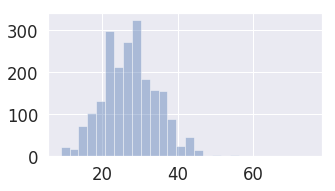

In [5]:
task_name = 'Multi-Targeting'
tasks = ['activity']
sub_task1 = ['RET','MKNK1','BRAF','SRC','RPS6KB1','TTK','MAPK15','PDPK1','PAK3']
sub_task2 = ['AURKA','PAK1','FGFR1','STK11','PAK3','MAP3K7','PIK3CA']
kinase_seq_embedding = pd.read_csv('../input/kinase_seq_embedding.csv')
smiles_kinase_activity = pd.read_csv('../input/smiles_kinase_activity.csv')
print('kinase count:',len(smiles_kinase_activity['kinase'].value_counts()))
print('similes count:',len(smiles_kinase_activity['smiles'].value_counts()))

seq_embeddings_dict = {}
for kinase in list(set(smiles_kinase_activity['kinase'].values)):
    seq_embeddings_dict[kinase] = [float(x) for x in kinase_seq_embedding.loc[kinase_seq_embedding['kinase']==kinase].embedding.values[0]\
                                 .replace("[", "").replace("]", "").replace(" ", "").split(',')]

smiles_kinase_activity['embedding'] = [seq_embeddings_dict[kinase] for kinase in smiles_kinase_activity['kinase'].values]

smilesList = list(set(smiles_kinase_activity.smiles.values))
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()

In [6]:
random_seed = 28
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 100

p_dropout= 0.1
fingerprint_dim = 500

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2
output_units_num = 1 # for regression model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model(nn.Module):

    def __init__(self, fingerprint_dim, output_units_num):
        super(Model, self).__init__()
        self.embedding1 = nn.Linear(fingerprint_dim, fingerprint_dim)
        self.embedding2 = nn.Linear(fingerprint_dim, fingerprint_dim)
        self.fused_embedding = nn.Linear(fingerprint_dim+100, fingerprint_dim)
        self.output = nn.Linear(fingerprint_dim, output_units_num)

    def forward(self, fingerprints, seq_embeddings):
        mol_embedding = F.relu(self.embedding1(fingerprints))
        mol_embedding = F.relu(self.embedding1(mol_embedding))         
        fused_embedding = F.relu(self.fused_embedding(torch.cat([mol_embedding,seq_embeddings],-1)))                 
        mol_prediction = self.output(fused_embedding)
            
        return mol_prediction

In [8]:
import rdkit.Chem as Chem
from rdkit.Chem import AllChem

def smiles_to_fps(data, fp_length, fp_radius=2):
    return stringlist2intarray(np.array([smile_to_fp(s, fp_length, fp_radius) for s in data]))

def smile_to_fp(s, fp_length, fp_radius):
    m = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(
        m, fp_radius, nBits=fp_length)).ToBitString()

def stringlist2intarray(A):
    return np.array([list(s) for s in A], dtype=int)

In [9]:
test_df = smiles_kinase_activity.sample(frac=1/10, random_state=random_seed) # test set
training_data = smiles_kinase_activity.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    test_df[task+'_normalized'] = (test_df[task]- mean)/std

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,activity,5.22636,0.79216,0.572409,1.383907


In [10]:
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = train_df[task].mean()
    mean_list.append(mean)
    std = train_df[task].std()
    std_list.append(std)
    mad = train_df[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats

,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,activity,5.226356,0.791763,0.572286,1.383509


In [11]:
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
for task in tasks:
    mean = valid_df[task].mean()
    mean_list.append(mean)
    std = valid_df[task].std()
    std_list.append(std)
    mad = valid_df[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats

,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,activity,5.22639,0.795342,0.573387,1.387095


In [12]:
# predict all values as mean of each ligand will get a MSE of 0.3683609544565635
smiles_variance = smiles_kinase_activity.groupby('smiles')['activity'].var(ddof=0) * smiles_kinase_activity.groupby('smiles')['smiles'].value_counts()
print(np.sqrt(smiles_variance.sum()/smiles_kinase_activity.shape[0]))

# predict all values as mean of each protein kinase will get a MSE of 0.5583972950594606
kinase_variance = smiles_kinase_activity.groupby('kinase')['activity'].var(ddof=0) * smiles_kinase_activity.groupby('kinase')['kinase'].value_counts()
print(np.sqrt(kinase_variance.sum()/smiles_kinase_activity.shape[0]))

0.6067693844481934
0.7473647274436619


In [13]:
model = Model(fingerprint_dim, output_units_num)
model.cuda()

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

802001
embedding1.weight torch.Size([500, 500])
embedding1.bias torch.Size([500])
embedding2.weight torch.Size([500, 500])
embedding2.bias torch.Size([500])
fused_embedding.weight torch.Size([500, 600])
fused_embedding.bias torch.Size([500])
output.weight torch.Size([1, 500])
output.bias torch.Size([1])


In [14]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.smiles.values
        y_true = batch_df['activity_normalized'].values
        name_list = batch_df.kinase.values
        seq_embeddings = list(batch_df.embedding.values)
        
        fingerprints = smiles_to_fps(batch_df['smiles'].values, fingerprint_dim)
        y_prediction = model(torch.Tensor(fingerprints), torch.Tensor(seq_embeddings))
        
        model.zero_grad()
        loss = loss_function(y_prediction, torch.Tensor(y_true).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.smiles.values
        y_true = batch_df['activity_normalized'].values
        name_list = batch_df.kinase.values
        seq_embeddings = list(batch_df.embedding.values)
        
        fingerprints = smiles_to_fps(batch_df['smiles'].values, fingerprint_dim)
        y_prediction = model(torch.Tensor(fingerprints), torch.Tensor(seq_embeddings))
        
        MAE = F.l1_loss(y_prediction, torch.Tensor(y_true).view(-1,1), reduction='none')        
        MSE = F.mse_loss(y_prediction, torch.Tensor(y_true).view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    eval_MAE_nomalized = np.array(eval_MAE_list).mean()
    eval_MSE_nomalized = np.array(eval_MSE_list).mean()
    eval_MAE = eval_MAE_nomalized * std_list[0]
    eval_MSE = eval_MSE_nomalized * std_list[0] * std_list[0]
    return eval_MAE, np.sqrt(eval_MSE)

In [ ]:
for epoch in range(80):
    train_MAE, train_RMSE = eval(model, train_df)
    valid_MAE, valid_RMSE = eval(model, valid_df)
    print(epoch, train_RMSE, valid_RMSE)
    torch.save(model, 'model_ecfp_protein_embedding'+start_time+'_'+str(epoch)+'.pt')
    %time train(model, train_df, optimizer, loss_function)

0 0.7971547591576911 0.80070477567334


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 2min 1s, sys: 228 ms, total: 2min 2s
Wall time: 2min 2s
1 0.5580183200497458 0.569042968383776


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CPU times: user 2min, sys: 176 ms, total: 2min 1s
Wall time: 2min 1s


In [ ]:
!nvidia-smi